# Random Forests

Nesse notebook, será desenvolvida uma análise preditiva com modelos de ensemble, Random Forest.

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from collections import defaultdict

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
#from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline

sns.set(font_scale=0.9)

# seed padrão
seed = 101

## Importando dataset

In [3]:
datapath = Path('../data')
outpath = Path('../models')

with open(f'{datapath}/data.pickle', 'rb') as file:
    data = pickle.load(file)

In [4]:
data.head(2)

,status_check_acc,duration,cred_history,purpose,cred_amount,savings,employment_since,installment,other_deb,resid_since,...,other_installment,housing,n_creds,job,n_liable_people,tel,foreign,cred_score,gender,social_status
0,0 DM,6,critical,radio/television,1169.0,None,>= 7 years,4,None,4,...,none,own,2,skilled,1,1,1,0,M,single
1,<200 DM,48,all paid,radio/television,5951.0,<100 DM,< 4 years,2,None,2,...,none,own,1,skilled,1,0,1,1,F,divorced/separated


## Separando variáveis preditoras e dependente (X e y)

In [5]:
X = data.drop('cred_score', axis=1).copy()
y = data['cred_score'].copy()

## Padronizando variáveis numéricas contínuas

As variáveis numéricas, porém discretas, serão tratadas como categóricas. No entanto, não serão sujeitas ao processo de `OneHotEncoding`.

**OBS:** apesar de não ser necessário padronizar variáveis para se trabalhar com modelos de árvore, vou manter essa etapa por fins de consistência, dado que adotei esse procedimento para o modelo de regressão logística.

In [6]:
continuous_vars = [col for col in X.columns if X[col].dtype == 'float']
print(continuous_vars)

['cred_amount']


<AxesSubplot:xlabel='cred_amount', ylabel='Count'>

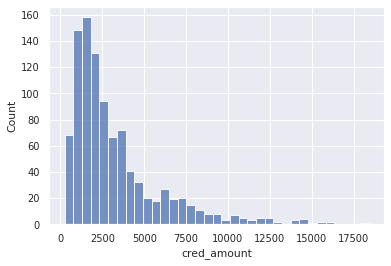

In [7]:
sns.histplot(X['cred_amount'])

**OBS:** como podemos inferir a partir do histograma acima, a variável cred_amount não segue uma distribuição normal. Assim, vamos apenas padronizá-la de forma que apenas a sua escala seja ajustada em torno de uma variância 1.

In [8]:
X['cred_amount'] = scale(X['cred_amount'])

<AxesSubplot:xlabel='cred_amount', ylabel='Count'>

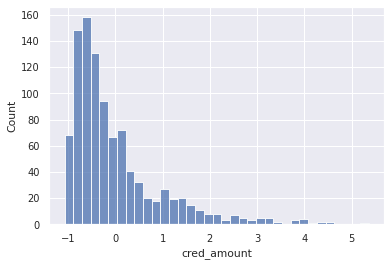

In [9]:
sns.histplot(X['cred_amount'])

## Label Encoding

Nesse passo, vamos dar um tratamento diferente às variáveis categóricas uma vez que `OneHotEncoding` pode prejudicar a performance de modelos de árvore ao criar um conjunto de features esparso. 

In [10]:
categorical_vars = [col for col in X.columns if X[col].dtype not in ['int', 'float']]
numerical_vars = [col for col in X.columns if col not in categorical_vars]

print('categorical_vars: ',categorical_vars)
print('\nnumerical_vars: ',numerical_vars)

categorical_vars:  ['status_check_acc', 'cred_history', 'purpose', 'savings', 'employment_since', 'other_deb', 'property', 'other_installment', 'housing', 'job', 'tel', 'foreign', 'gender', 'social_status']

numerical_vars:  ['duration', 'cred_amount', 'installment', 'resid_since', 'age', 'n_creds', 'n_liable_people']


In [11]:
label_encoders = defaultdict()  # vou armazenar o encoder caso precise fazer a decodificação novamente

for var in categorical_vars:
    le = LabelEncoder()
    label_encoders[var] = le.fit(X[var])
    X[var] = label_encoders[var].transform(X[var])

# para fazer a decodificação, basta executar o comando abaixo na coluna desejada
# label_encoders['status_check_acc'].inverse_transform(X['status_check_acc'])

## Train Test Split

Nesse passo, vamos separar um conjunto de treino e um de teste (_holdout_) para posterior avaliação fora da amostra. Como a amostra contém apenas 1000 registros, reservaremos 20% para compor o conjunto de teste. Será selecionado o modelo com o melhor *cross_validation_score* dentro da amostra de treino.

**OBS:** é importante que seja definido o parâmetro `stratify` para que sejam mantidas as mesmas proporções de clientes com score bom e ruim observadas na amostra.

In [12]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

## Estimando modelo de Random Forests

Com esse modelo, esperamos ter uma medida de comparação de um modelo de ensemble em relação ao modelo de Decision Trees tradicional.

-----

É importante, nesse passo, discutir qual métrica utilizar para avaliar o modelo, levando em consideração o desbalanceamento observado da amostra. 

Duas candidatas razoáveis são: `ROC AUC Score` e `f1`.

Analisando o problema de negócio sob a ótica do Banco (agente que vai conceder o empréstimo), queremos evitar duas situações: 

1. Emprestar erroneamente recursos para um cliente classificado como de baixo risco, enquanto que, na verdade, o cliente é de alto risco (**Falso Positivo**).
2. Não conceder crédito a um cliente de baixo risco classificado erroneamente como de alto risco. (**Falso Negativo**)

**Raciocínio:** Em outras palavras, estamos interessados em reduzir, ao máximo, o número de Falsos Positivos e Falsos Negativos.


-----
<font color='red'>**OBS:**</font>
No entanto, devemos atentar para o fato de que, em um dataset desbalanceado, o número de verdadeiros positivos tende a ser superestimado. Logo, a métrica `roc_auc_score` pode não ser a mais adequada para este problema devido à possibilidade de esta ser superestimada. 

Sendo assim, vamos prosseguir a análise utilizando a métrica `f1` para priorizar `precision` e `recall`.

$$ 
F_{\beta} = (1+\beta^2)\frac{precicion*recall}{\beta^2 * precision + recall}
$$

$$
precision = \frac{tp}{tp + fp},~~recall=\frac{tn}{tn+fp}
$$

In [13]:
# grid de parâmetros
param_grid={"max_depth":[*range(1, 13, 1)],
            "n_estimators":[*range(50, 301, 50)],
            #"min_samples_leaf":np.linspace(0.2, 1.2, 6),
            "criterion":["gini", "entropy"], 
            "class_weight":[None,"balanced"]}

In [14]:
#%%capture --no-display
# capturando warnings

start_train_time = datetime.now()

rf = RandomForestClassifier(oob_score=False, random_state= seed, n_jobs=-1)
rf_cv = GridSearchCV(rf, param_grid, cv=3, scoring='f1', verbose=1)  # 3 fold devido ao número de registros
rf_cv.fit(X_train, y_train)

end_train_time = datetime.now()

train_time = end_train_time - start_train_time

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [15]:
print('Logistic Regression best params:', rf_cv.best_params_)
print('Logistic Regression best F1 score:', rf_cv.best_score_)

Logistic Regression best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 50}
Logistic Regression best F1 score: 0.6009158604335004


### Avaliando o modelo de Random Forest

vamos começar avaliando o modelo no conjunto holdout

In [16]:
start_eval_time = datetime.now()

y_pred = rf_cv.predict(X_holdout)  # calculando previsões com threshold de treino
y_pred_proba = rf_cv.predict_proba(X_holdout)[:,1]  # calculando probabilidades

end_eval_time = datetime.now()

eval_time = end_eval_time - start_eval_time

#### Matriz de Confusão e Relatório de Classificação

Na matriz de confusão, temos as seguintes informações: 

$
\left[
  \begin{matrix}
   tp & fp  \\
   fn & tn  
  \end{matrix} 
\right]
  = 
\left[
  \begin{matrix}
   true~positives & false~positives  \\
   false~negatives & true~negatives  
  \end{matrix}
\right]
$

In [17]:
print(confusion_matrix(y_holdout, y_pred))

[[111  29]
 [ 18  42]]


In [18]:
print(classification_report(y_holdout, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83       140
           1       0.59      0.70      0.64        60

    accuracy                           0.77       200
   macro avg       0.73      0.75      0.73       200
weighted avg       0.78      0.77      0.77       200



#### Curva ROC

Na presente aplicação, a curva ROC se faz relevante pois tende a ser insensível a conjuntos de dados com proporções de classes desbalanceadas. 

Isto posto, a área abaixo da curva ROC é uma importante métrica para avaliar o desempenho do modelo.

----

Vamos começar calculando as taxas de verdadeiros positivos e falsos positivos.

In [19]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_holdout, y_pred_proba)

Text(0, 0.5, 'Taxa de Verdadeiros Positivos')

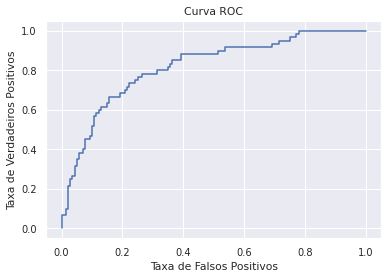

In [20]:
plt.plot(false_pos_rate, true_pos_rate)

# labels
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

In [21]:
auc_score = roc_auc_score(y_holdout, y_pred)
print('ROC AUC score:', auc_score)

ROC AUC score: 0.7464285714285713


#### feature importance

In [22]:
best_dt = rf_cv.best_estimator_

In [23]:
feature_importance = pd.DataFrame({
    'features':X.columns,
    'importance':best_dt.feature_importances_
})

In [24]:
# top 10 features mais importantes para Decision Tree com critério de gini
feature_importance.sort_values('importance', ascending=False).head(10)

,features,importance
0,status_check_acc,0.202206
4,cred_amount,0.127560
1,duration,0.112991
11,age,0.082279
5,savings,0.062725
2,cred_history,0.046737
6,employment_since,0.042990
3,purpose,0.039734
10,property,0.036954
7,installment,0.034095


## Sintetizando métricas e exportando modelo

Avaliando e exportando métricas no conjunto holdout

### Mean Squared Error

Para comparação com outros modelos

In [25]:
mse = MSE(y_holdout, y_pred)
rmse = mse**(1/2)

### Exportando métricas

In [26]:
precision = precision_score(y_holdout, y_pred)
recall = recall_score(y_holdout, y_pred)
accuracy = accuracy_score(y_holdout, y_pred)
balanced_accuracy = balanced_accuracy_score(y_holdout, y_pred)
f1 = f1_score(y_holdout, y_pred)

# confusion_matrix
matrix = confusion_matrix(y_holdout, y_pred)

In [27]:
metrics_dict = {
    'precision'        : precision,
    'recall'           : recall,
    'accuracy'         : accuracy,
    'balanced_accuracy': balanced_accuracy,
    'f1_holdout'       : f1,
    'f1_train'         : rf_cv.best_score_,
    'roc_auc_score'    : auc_score,
    'confusion_matrix' : matrix,
    'train_time'       : train_time,
    'eval_time'        : eval_time
}

### Exportando métricas

In [28]:
with open(f'{outpath}/random_forest_holdout_metrics.pickle', 'wb') as file:
    pickle.dump(metrics_dict, file)

### Exportando modelo

In [29]:
best_model = rf_cv.best_estimator_

In [30]:
with open(f'{outpath}/random_forest.pickle', 'wb') as file:
    pickle.dump(best_model, file)

**Fim!**